<p style="font-family:Roboto; font-size: 28px; color: magenta"> Python for NLP: Movie Sentiment Analysis using Deep Learning in Keras</p>

In [ ]:
'''Text classification is one of the most common natural language processing tasks'''

In [1]:
'''
 We will use three different types of deep neural networks: 
 Densely connected neural network (Basic Neural Network), 
 Convolutional Neural Network (CNN) and 
 Long Short Term Memory Network (LSTM), which is a variant of Recurrent Neural Networks
'''

'\n We will use three different types of deep neural networks: \n Densely connected neural network (Basic Neural Network), \n Convolutional Neural Network (CNN) and \n Long Short Term Memory Network (LSTM), which is a variant of Recurrent Neural Networks\n'

In [2]:
'''CSV file. The file contains 50,000 records and two columns: review and sentiment. 
The review column contains text for the review and the sentiment column contains sentiment for the review. 
The sentiment column can have two values i.e. "positive" and "negative" 
which makes our problem a binary classification problem''' 

'CSV file. The file contains 50,000 records and two columns: review and sentiment. \nThe review column contains text for the review and the sentiment column contains sentiment for the review. \nThe sentiment column can have two values i.e. "positive" and "negative" \nwhich makes our problem a binary classification problem'

<p style="font-family:Roboto; font-size: 28px; color: magenta"> Importing Required Libraries</p>

In [68]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers  import Activation, Dropout, Dense, LSTM
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers  import Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer 

<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _Importing and Analyzing the Dataset</p>

In [8]:
movie_reviews = pd.read_csv("./data/IMDB Dataset.csv")

movie_reviews.isnull().values.any()

movie_reviews.shape

(50000, 2)

In [9]:
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [10]:
movie_reviews["review"][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

<Axes: xlabel='sentiment', ylabel='count'>

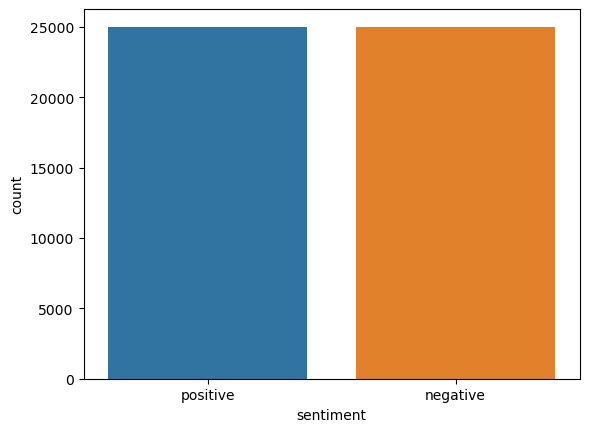

In [11]:
import seaborn as sns

sns.countplot(x='sentiment', data=movie_reviews, hue='sentiment')

<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _Data Preprocessing</p>

In [12]:
TAG_RE = re.compile(r'<[^>]+>')
'''The remove_tags function simply replaces anything between opening and closing <> with an empty space.'''
def remove_tags(text):
    return TAG_RE.sub('', text)

In [13]:
'''
we will define a function that takes a text string as a parameter and then performs preprocessing on the string 
to remove special characters and HTML tags from the string. 
Finally, the string is returned to the calling function
'''
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    '''For instance, when you remove an apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. 
    Hence, we are left with single character "s".'''
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    '''Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. 
    Finally, we remove the multiple spaces from our text as well.'''
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [14]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [15]:
X[3]

'Basically there a family where little boy Jake thinks there a zombie in his closet his parents are fighting all the time This movie is slower than soap opera and suddenly Jake decides to become Rambo and kill the zombie OK first of all when you re going to make film you must Decide if its thriller or drama As drama the movie is watchable Parents are divorcing arguing like in real life And then we have Jake with his closet which totally ruins all the film expected to see BOOGEYMAN similar movie and instead watched drama with some meaningless thriller spots out of just for the well playing parents descent dialogs As for the shots with Jake just ignore them '

In [16]:
'''Next, we need to convert our labels into digits.'''
y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [18]:
'''Finally, we need to divide our dataset into train and test sets. '''
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _Preparing the Embedding Layer</p>

In [ ]:
'''As a first step, we will use the Tokenizer class to create a word-to-index dictionary'''
tokenizer = Tokenizer(num_words=5000)
 

In [20]:
tokenizer.fit_on_texts(X_train)

In [21]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [22]:
'''
We set the maximum size of each list to 100. You can try a different size. 
The lists with size greater than 100 will be truncated to 100. For the lists that have length less than 100, 
we will add 0 at the end of the list until it reaches the max length. 
This process is called padding
'''
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [25]:
'''We will use GloVe embeddings to create our feature matrix. In the following script we load the GloVe word embeddings 
and create a dictionary 
that will contain words as keys and their corresponding embedding list as values'''
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('./data/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [26]:
'''
Finally, we will create an embedding matrix where each row number will correspond to the index of the word in the corpus. 
The matrix will have 100 columns where each column will contain the GloVe word embeddings for the words in our corpus
'''
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

<p style="font-family:Roboto; font-size: 28px; color: magenta"> Text Classification with Simple Neural Network</p>

In [30]:
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [31]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │     9,254,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,254,700 (35.30 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,254,700 (35.30 MB)

None


In [ ]:
'''Since there are 92547 words in our corpus and each word is represented as a 100-dimensional vector, 
the number of trainable parameters will be 92547x100 in the embedding layer'''

'''
Finally in the dense layer the number of parameters are 10000 (from the flattening layer) 
and 1 for the bias parameter, for a total of 10001
'''

<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _Train our model</p>

In [32]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - acc: 0.6221 - loss: 0.6582 - val_acc: 0.7354 - val_loss: 0.5347
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - acc: 0.7678 - loss: 0.4898 - val_acc: 0.7437 - val_loss: 0.5214
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - acc: 0.7957 - loss: 0.4473 - val_acc: 0.7427 - val_loss: 0.5211
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - acc: 0.8035 - loss: 0.4322 - val_acc: 0.7440 - val_loss: 0.5254
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - acc: 0.8094 - loss: 0.4172 - val_acc: 0.7349 - val_loss: 0.5422
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - acc: 0.8239 - loss: 0.3972 - val_acc: 0.7409 - val_loss: 0.5399


<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _Evaluate our model</p>

In [33]:
score = model.evaluate(X_test, y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.7373 - loss: 0.5427


In [48]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5390700101852417
Test Accuracy: 0.739799976348877


In [ ]:
'''Once you execute the above script, you will see that we get a test accuracy of 74.68%. 
Our training accuracy was 82%. This means that our model is overfitting on the training set'''

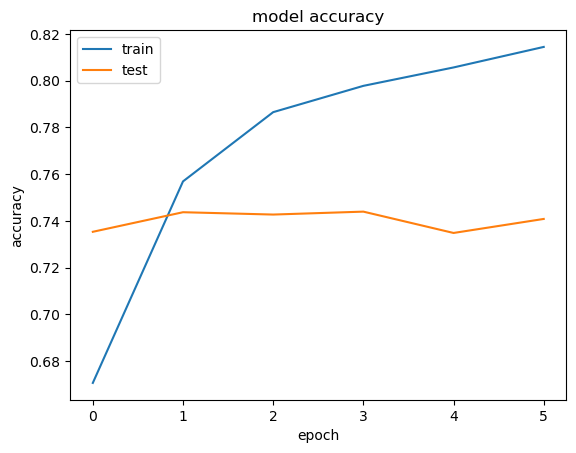

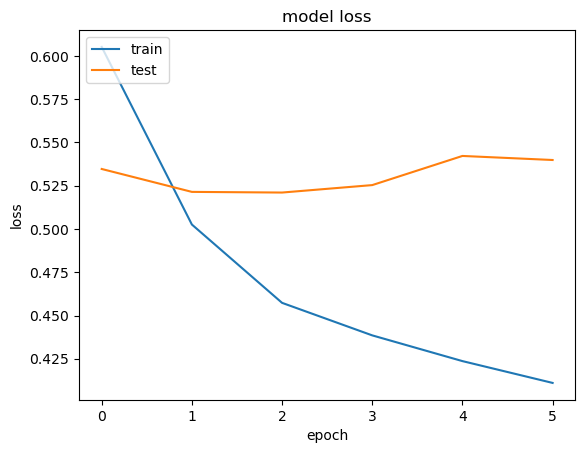

In [47]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

<p style="font-family:Roboto; font-size: 28px; color: magenta"> Text Classification with a Convolutional Neural Network</p>

In [ ]:
'''Convolutional neural network is a type of network that is primarily used for 2D data classification, such as images'''
'''Convolutional neural networks have been found to work well with text data as well'''

In [53]:
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D,  Dense

In [ ]:
'''Let's create a simple convolutional neural network with 1 convolutional layer and 1 pooling layer'''
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [59]:
print(model.summary())

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │     9,254,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_3          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,254,700 (35.30 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,254,700 (35.30 MB)

None


<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _Train our model</p>

In [64]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 157ms/step - acc: 0.8727 - loss: 0.3034 - val_acc: 0.8432 - val_loss: 0.3485
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 140ms/step - acc: 0.8927 - loss: 0.2699 - val_acc: 0.8460 - val_loss: 0.3418
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 42s 167ms/step - acc: 0.9131 - loss: 0.2338 - val_acc: 0.8500 - val_loss: 0.3409
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 37s 146ms/step - acc: 0.9337 - loss: 0.1972 - val_acc: 0.8481 - val_loss: 0.3440
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 33s 131ms/step - acc: 0.9457 - loss: 0.1724 - val_acc: 0.8443 - val_loss: 0.3499
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 33s 131ms/step - acc: 0.9584 - loss: 0.1472 - val_acc: 0.8455 - val_loss: 0.3543


<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _Evaluate our model</p>

In [65]:
score = model.evaluate(X_test, y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - acc: 0.8495 - loss: 0.3452


In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

In [ ]:
'''If you compare the training and test accuracy, you will see that the training accuracy for CNN will be around 96%,
which is greater than the training accuracy of the simple neural network. The test accuracy is around 85% for the CNN, 
which is also greater than the test accuracy for the simple neural network, which was around 74%'''

In [ ]:
'''However our CNN model is still overfitting as there is a vast difference between the training and test accuracy'''

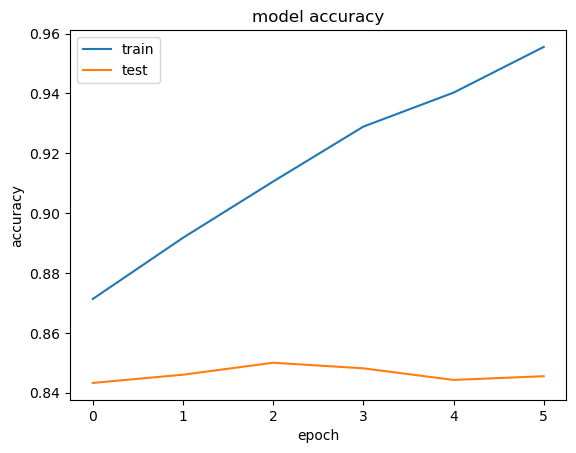

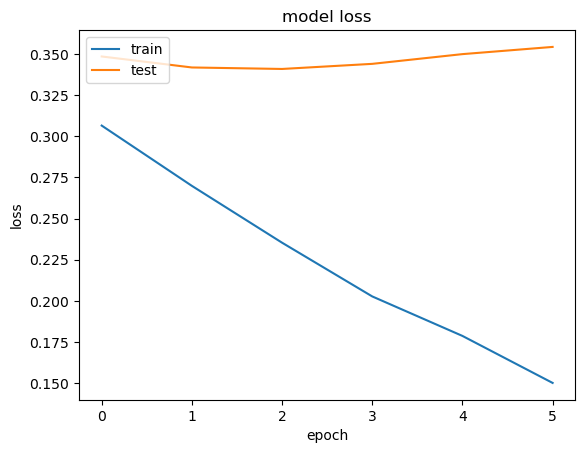

In [66]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

<p style="font-family:Roboto; font-size: 28px; color: magenta"> Text Classification with Recurrent Neural Network (LSTM)</p>

In [ ]:
'''Recurrent neural network is a type of neural network that is proven to work well with sequence data. 
Since text is actually a sequence of words, 
a recurrent neural network is an automatic choice to solve text-related problems.'''

In [69]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
'''We start by initializing a sequential model followed by the creation of the embedding layer. 
Next, we create an LSTM layer with 128 neurons'''

In [70]:
print(model.summary())

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ ?                      │     9,254,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,254,700 (35.30 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,254,700 (35.30 MB)

None


<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _Train our model</p>

In [71]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 146s 547ms/step - acc: 0.6337 - loss: 0.6193 - val_acc: 0.7881 - val_loss: 0.4529
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 165s 661ms/step - acc: 0.7897 - loss: 0.4550 - val_acc: 0.8134 - val_loss: 0.4099
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 180s 722ms/step - acc: 0.8111 - loss: 0.4117 - val_acc: 0.8161 - val_loss: 0.3950
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 136s 454ms/step - acc: 0.8312 - loss: 0.3798 - val_acc: 0.8407 - val_loss: 0.3706
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 143s 573ms/step - acc: 0.8389 - loss: 0.3605 - val_acc: 0.8422 - val_loss: 0.3556
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 113s 454ms/step - acc: 0.8502 - loss: 0.3402 - val_acc: 0.8526 - val_loss: 0.3393


<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _Evaluate our model</p>

In [72]:
score = model.evaluate(X_test, y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 75ms/step - acc: 0.8475 - loss: 0.3457


In [73]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3409697115421295
Test Accuracy: 0.8482999801635742


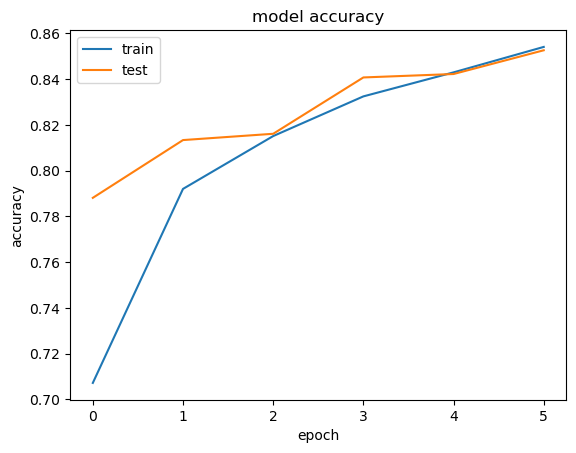

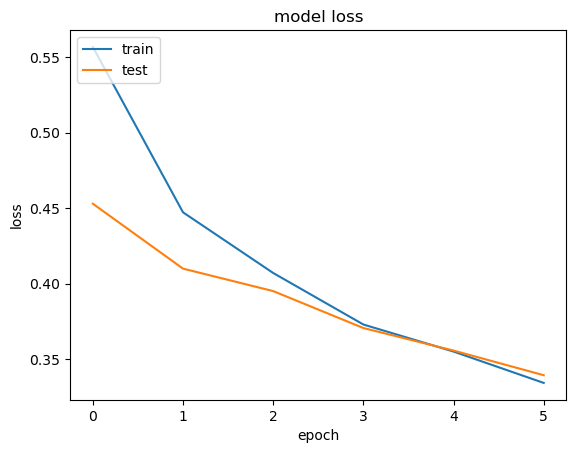

In [74]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
'''The output shows that the difference between the accuracy values for training and test sets 
is much smaller compared to the simple neural network and CNN. 
Similarly, the difference between the loss values is also negligible, which shows that our model is not overfitting. 
We can conclude that for our problem, RNN is the best algorithm.'''

<p style="font-family:Roboto; font-size: 28px; color: magenta"> Making Predictions on Single Instance</p>

In [75]:
instance = X[57]
print(instance)

I laughed all the way through this rotten movie It so unbelievable woman leaves her husband after many years of marriage has breakdown in front of real estate office What happens The office manager comes outside and offers her job Hilarious Next thing you know the two women are going at it Yep they re lesbians Nothing rings true in this Lifetime for Women with nothing better to do movie Clunky dialogue like don want to spend the rest of my life feeling like had chance to be happy and didn take it doesn help There a wealthy distant mother who disapproves of her daughter new relationship sassy black maid unbelievable that in the year film gets made in which there a sassy black maid Hattie McDaniel must be turning in her grave The woman has husband who freaks out and wants custody of the snotty teenage kids Sheesh No cliche is left unturned 


In [ ]:
'''You can clearly see that this is a negative review. 
To predict the sentiment of this review, we have to convert this review into numeric form. 
We can do so using the tokenizer that we created in the word embedding section. 
The text_to_sequences method will convert the sentence into its numeric counterpart'''

'''Next, we need to pad our input sequence as we did for our corpus. 
Finally, we can use the predict method of our model and pass it our processed input sequence'''

In [76]:
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

model.predict(instance)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step


array([[0.5349923]], dtype=float32)